In [75]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
from tqdm.auto import tqdm, trange
import xgboost as xgb
import joblib
from sklearn.model_selection import cross_validate
import zipfile

from src.model import tscv, ClippedOutputRegressor
from src.feature_engineering import get_feature_cols, df_to_X_y, drop_non_features, add_lagged_features


%run constants.py

baseline_reg = joblib.load(os.path.join(MODELS_DIR, 'xgb-baseline.model'))

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn]:
    print("  %s: %s" %(module.__name__, module.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.1
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2


The original dataset contains item prices, so maybe that carries some information on the sales. Let's explore that.

In [29]:
with zipfile.ZipFile(os.path.join(RAW_DATA_DIR, 'competitive-data-science-predict-future-sales.zip'), 'r') as datasets_file:
    sales_train = pd.read_csv(datasets_file.open('sales_train.csv'))

In [30]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


First thing we notice is we have negative item prices.

Now let's see the maximum: it says it's ~308,000. Since it doesn't say the currency I'll assume it's russian rubles, and that would give us between $\$5,800.00$ and $\$10,164.00$, depending on the quote at the time. This seems unreasonably high.

Since I don't want to deal with it, I'll just use the median prices for each month.

In [24]:
median_prices = sales_train.groupby(['item_id', 'shop_id', 'date_block_num'])['item_price'].median().reset_index().rename(columns={'item_price': 'median_item_price'})
median_prices.describe()

,item_id,shop_id,date_block_num,median_item_price
count,1.609124e+06,1.609124e+06,1.609124e+06,1.609124e+06
mean,1.068099e+04,3.280585e+01,1.466479e+01,7.904711e+02
std,6.238883e+03,1.653701e+01,9.542322e+00,1.552170e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-02
25%,5.045000e+03,2.100000e+01,6.000000e+00,1.990000e+02
50%,1.049700e+04,3.100000e+01,1.400000e+01,3.990000e+02
75%,1.606000e+04,4.700000e+01,2.300000e+01,8.985000e+02
max,2.216900e+04,5.900000e+01,3.300000e+01,3.079800e+05


Unfortunately the high price still appears in the median... Let's check these extremes before continuing then.

In [31]:
sales_train[sales_train['item_price'] > 3e5]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [32]:
sales_train[sales_train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


Well, both cases appear just once. Let's see how it looks when we remove them.

In [36]:
sales_train[(sales_train['item_price'] >=0) & (sales_train['item_price'] < 3e5)].describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06
mean,1.456992e+01,3.300174e+01,1.019723e+04,8.907489e+02,1.242641e+00
std,9.422989e+00,1.622697e+01,6.324298e+03,1.720490e+03,2.618835e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,2.169000e+03


A lot more reasonable. Let's just use that and continue.

In [46]:
sales_train_clipped = sales_train[(sales_train['item_price'] >=0) & (sales_train['item_price'] < 3e5)]

Now let's see some aggregate data.

In [51]:
prices_stats = sales_train_clipped.groupby(['item_id', 'shop_id', 'date_block_num']).agg({'item_price': ['min', 'max', 'mean', 'median']}).reset_index()
prices_stats.columns = ['_'.join(col).strip('_') for col in prices_stats.columns.values]
prices_stats.describe()

,item_id,shop_id,date_block_num,item_price_min,item_price_max,item_price_mean,item_price_median
count,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06
mean,1.068099e+04,3.280586e+01,1.466480e+01,7.832010e+02,7.990592e+02,7.906941e+02,7.902802e+02
std,6.238884e+03,1.653701e+01,9.542325e+00,1.514060e+03,1.554998e+03,1.532592e+03,1.533163e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,9.000000e-02,9.000000e-02,9.000000e-02
25%,5.045000e+03,2.100000e+01,6.000000e+00,1.990000e+02,1.990000e+02,1.990000e+02,1.990000e+02
50%,1.049700e+04,3.100000e+01,1.400000e+01,3.980000e+02,3.990000e+02,3.990000e+02,3.990000e+02
75%,1.606000e+04,4.700000e+01,2.300000e+01,8.490000e+02,8.990000e+02,8.985000e+02,8.985000e+02
max,2.216900e+04,5.900000e+01,3.300000e+01,5.099900e+04,5.920000e+04,5.099900e+04,5.099900e+04


Just to make sure these columns are not redundant, let's plot a correlation matrix.

<AxesSubplot:>

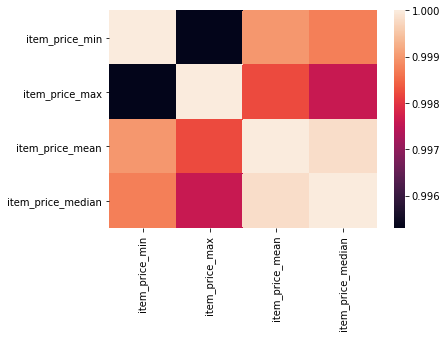

In [54]:
corr_df = prices_stats[['item_price_min', 'item_price_max', 'item_price_mean', 'item_price_median']].corr()
sns.heatmap(corr_df)

Looks like we only need one of them since the correlation between all pairs is >0.99.

Let's add the categories metadata and grab other statistics now.

In [60]:
categories_meta = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'item-categories-metadata.parquet'))
sales_train_clipped = sales_train_clipped.merge(categories_meta, on='item_id', how='left', sort=False)

In [64]:
sales_train_clipped.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,category_name,subcategory_name
0,02.01.2013,0,59,22154,999.00,1.0,37,Кино,Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,58,Музыка,Винил
2,05.01.2013,0,25,2552,899.00,-1.0,58,Музыка,Винил
3,06.01.2013,0,25,2554,1709.05,1.0,58,Музыка,Винил
4,15.01.2013,0,25,2555,1099.00,1.0,56,Музыка,CD фирменного производства


In [65]:
stats_confs = [{'col': 'item_shop_price_median',
                'index_cols': ['item_id', 'shop_id']},
               {'col': 'cat_price_median',
                'index_cols': ['category_name']},
               {'col': 'cat_shop_price_median',
                'index_cols': ['category_name', 'shop_id']},
               {'col': 'item_price_median',
                'index_cols': ['item_id']}]

In [66]:
train_set = pd.read_parquet(os.path.join(PROCESSED_DATA_DIR, 'train-set.parquet'))

In [69]:
train_set_stats = train_set.merge(categories_meta, on='item_id')
for conf in stats_confs:
    idx = conf['index_cols'] + ['date_block_num']
    stat_df = sales_train_clipped.groupby(idx)['item_price'].median().reset_index().rename(columns={'item_price': conf['col']})
    train_set_stats = train_set_stats.merge(stat_df, on=idx, how='left', sort=False)
train_set_stats

,item_id,shop_id,date_block_num,item_cnt_month,item_category_id,category_name,subcategory_name,item_shop_price_median,cat_price_median,cat_shop_price_median,item_price_median
0,5037,5,10,0.0,19,Игры,PS3,NaN,1699.0,1999.0,NaN
1,5037,4,10,0.0,19,Игры,PS3,NaN,1699.0,1649.0,NaN
2,5037,6,10,0.0,19,Игры,PS3,NaN,1699.0,1999.0,NaN
3,5037,3,10,0.0,19,Игры,PS3,NaN,1699.0,1499.0,NaN
4,5037,2,10,0.0,19,Игры,PS3,NaN,1699.0,1499.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5140795,969,46,33,0.0,37,Кино,Blu-Ray,NaN,299.0,299.0,198.0
5140796,969,41,33,0.0,37,Кино,Blu-Ray,NaN,299.0,324.0,198.0
5140797,969,44,33,1.0,37,Кино,Blu-Ray,198.0,299.0,249.0,198.0
5140798,969,39,33,0.0,37,Кино,Blu-Ray,NaN,299.0,299.0,198.0


We can see some NaNs. Let's check their distribution on each column.

In [73]:
train_set_stats.isnull().sum(axis=0)

item_id                         0
shop_id                         0
date_block_num                  0
item_cnt_month                  0
item_category_id                0
category_name                   0
subcategory_name                0
item_shop_price_median    4636343
cat_price_median             2898
cat_shop_price_median      350899
item_price_median         2686278
dtype: int64

Let's use `cat_price_median` to imput the other columns since it's the one with the least amount of NaNs. The remaining NaNs will be filled with `-999`.

In [74]:
cols_to_imput = ['item_shop_price_median', 'cat_shop_price_median', 'item_price_median']
train_set_stats_complete = train_set_stats.copy()
for col in cols_to_imput:
    train_set_stats_complete.loc[train_set_stats_complete[col].isnull(), col] = train_set_stats_complete.loc[train_set_stats_complete[col].isnull(), 'cat_price_median']
train_set_stats_complete.fillna(-999)

,item_id,shop_id,date_block_num,item_cnt_month,item_category_id,category_name,subcategory_name,item_shop_price_median,cat_price_median,cat_shop_price_median,item_price_median
0,5037,5,10,0.0,19,Игры,PS3,1699.0,1699.0,1999.0,1699.0
1,5037,4,10,0.0,19,Игры,PS3,1699.0,1699.0,1649.0,1699.0
2,5037,6,10,0.0,19,Игры,PS3,1699.0,1699.0,1999.0,1699.0
3,5037,3,10,0.0,19,Игры,PS3,1699.0,1699.0,1499.0,1699.0
4,5037,2,10,0.0,19,Игры,PS3,1699.0,1699.0,1499.0,1699.0
...,...,...,...,...,...,...,...,...,...,...,...
5140795,969,46,33,0.0,37,Кино,Blu-Ray,299.0,299.0,299.0,198.0
5140796,969,41,33,0.0,37,Кино,Blu-Ray,299.0,299.0,324.0,198.0
5140797,969,44,33,1.0,37,Кино,Blu-Ray,198.0,299.0,249.0,198.0
5140798,969,39,33,0.0,37,Кино,Blu-Ray,299.0,299.0,299.0,198.0


There's a lot of other features we can get from this (eg: rank features, ratios, etc), but let's leave it at that for now and test it out. For that we need to add them as lagged features.

In [90]:
train_set_cv = train_set.merge(categories_meta, on='item_id')
train_set_cv = add_lagged_features(train_set_cv, train_set_stats_complete, [conf['col'] for conf in stats_confs], fill_value=-999, max_lag=6)

In [91]:
train_set_cv

,item_id,shop_id,date_block_num,item_cnt_month,item_category_id,category_name,subcategory_name,f__item_shop_price_median_1,f__cat_price_median_1,f__cat_shop_price_median_1,...,f__cat_shop_price_median_4,f__item_price_median_4,f__item_shop_price_median_5,f__cat_price_median_5,f__cat_shop_price_median_5,f__item_price_median_5,f__item_shop_price_median_6,f__cat_price_median_6,f__cat_shop_price_median_6,f__item_price_median_6
0,5037,5,10,0.0,19,Игры,PS3,-999.0,-999.0,-999.0,...,-999.000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,5037,4,10,0.0,19,Игры,PS3,-999.0,-999.0,-999.0,...,-999.000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,5037,6,10,0.0,19,Игры,PS3,-999.0,-999.0,-999.0,...,-999.000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,5037,3,10,0.0,19,Игры,PS3,-999.0,-999.0,-999.0,...,-999.000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,5037,2,10,0.0,19,Игры,PS3,-999.0,-999.0,-999.0,...,-999.000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5140795,969,46,33,0.0,37,Кино,Blu-Ray,299.0,299.0,299.0,...,332.665,242.0,399.0,399.0,299.0,248.0,399.0,399.0,299.0,298.0
5140796,969,41,33,0.0,37,Кино,Blu-Ray,299.0,299.0,299.0,...,299.000,242.0,399.0,399.0,299.0,248.0,399.0,399.0,399.0,298.0
5140797,969,44,33,1.0,37,Кино,Blu-Ray,299.0,299.0,399.0,...,299.000,242.0,399.0,399.0,374.0,248.0,399.0,399.0,399.0,298.0
5140798,969,39,33,0.0,37,Кино,Blu-Ray,299.0,299.0,299.0,...,399.000,242.0,399.0,399.0,399.0,248.0,399.0,399.0,399.0,298.0


In [92]:
X_train, y_train = df_to_X_y(train_set_cv)

scores = cross_validate(baseline_reg, X_train, y=y_train,
                        cv=tscv.split(train_set_cv['date_block_num']),
                        verbose=2, scoring='neg_root_mean_squared_error')
scores

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................................................. , total=  10.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


[CV] ................................................. , total=  11.0s
[CV]  ................................................................
[CV] ................................................. , total=  11.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.4s finished


{'fit_time': array([8.69499445, 9.63412666, 9.88703394]),
 'score_time': array([1.40544105, 1.38509321, 1.42111278]),
 'test_score': array([-0.94250256, -1.05278755, -1.00804261])}

In [93]:
np.mean(scores['test_score']), np.std(scores['test_score'])

(-1.0011109082762657, 0.045289667517037016)